In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lsst.sims.movingObjects import Orbits

File Granvik+\_2018_Icarus.dat contains a realization of the NEO model
described in

Granvik, Morbidelli, Jedicke, Bolin, Bottke, Beshore, Vokrouhlicky,
Nesvorny, and Michel (2018). Debiased orbit and absolute-magnitude
distributions for near-Earth objects. [Icarus](https://www.sciencedirect.com/science/article/pii/S0019103517307017)

The file Granvik+\_2018_Icarus.dat contains 802,000 synthetic NEOs with
17<H<25 parameterized by their orbits and absolute magnitudes. The 7
columns in the file are

1) semimajor axis [au]

2) eccentricity

3) inclination [deg]

4) longitude of ascending node [deg]

5) argument of perihelion [deg]

6) mean anomaly [deg]

7) absolute magnitude

In [2]:
#modelfile = '/epyc/users/lynnej/neo/Granvik+_2018_Icarus.dat'
modelfile = '/epyc/users/lynnej/sso/granvik/granvik.orb'
cols = ['a', 'e', 'inc', 'Omega', 'argPeri', 'meanAnomaly', 'epoch', 'H']

model = pd.read_csv(modelfile, delim_whitespace=True, names=cols, skiprows=1)

In [3]:
print(len(model))
model[0:5]

801999


,a,e,inc,Omega,argPeri,meanAnomaly,epoch,H
0,1.682046,0.275324,25.924536,350.926636,169.683060,46.401562,2459853.5,24.683197
1,2.480214,0.546448,14.240792,316.509247,121.685623,279.612305,2459853.5,24.843449
2,1.941440,0.620780,13.679822,175.087372,8.245143,129.364609,2459853.5,24.954794
3,1.114843,0.548071,37.906609,37.110592,209.261627,120.817390,2459853.5,24.342936
4,2.038636,0.573892,1.807318,44.628555,300.932587,223.581436,2459853.5,24.924656


In [4]:
# Read MOIDS
moidfile = '/epyc/users/lynnej/sso/granvik/granvik_moids.txt'
moids = pd.read_csv(moidfile, delim_whitespace=True, names=['n', 'MOID'], skiprows=1)
print(len(moids))
moids[0:5]

801999


,n,MOID
0,1,0.228778
1,2,0.196132
2,3,0.212526
3,4,0.245028
4,5,0.004669


In [5]:
model = model.assign(MOID=moids['MOID'], epoch=59853.0)
model[-5:-1]

,a,e,inc,Omega,argPeri,meanAnomaly,epoch,H,MOID
801994,2.877656,0.607120,6.684607,39.764286,118.446182,265.229523,59853.0,23.330488,0.159403
801995,1.563997,0.207188,28.263660,82.046822,135.846954,101.014885,59853.0,24.990154,0.419803
801996,2.679385,0.535874,7.462100,272.786926,227.803268,153.444550,59853.0,23.996401,0.294266
801997,1.592931,0.826241,43.307148,43.215237,337.204224,107.381775,59853.0,24.795914,0.113600


In [6]:
model = model.assign(q = model.a * (1 - model.e))
model = model.assign(objId = np.arange(0, len(model), 1))
pha = model.query('MOID <= 0.05') # and H <=22')
print(len(pha))

143742


In [14]:
# Write a subset of the Granvik orbits to disk, then write 500 object chunks.
# But put them into an orbit object first, so they also get seds (which will then stay consistent)

subsetLen = 5000
subpieces = 500
root = 'granvik_5k'

subset = Orbits()
subset.setOrbits(model.sample(subsetLen).drop('q', axis=1))
print(len(model), len(subset), len(subset.orbits.objId.unique()))
subset.orbits.to_csv('%s.txt' % root, index=False, sep=' ')

x = np.arange(0, subsetLen+1, subpieces)
try:
    os.mkdir('split')
except FileExistsError:
    pass
for i, (xi, xo) in enumerate(zip(x[:-1], x[1:])):
    subset.orbits[xi:xo].to_csv('split/%s_%d.txt' % (root, i), index=False, sep=' ')

801999 5000 5000


In [15]:
subsetLen = 5000
subpieces = 500
root = 'granvik_pha_5k'

subset = Orbits()
subset.setOrbits(model.sample(subsetLen).drop('q', axis=1))
print(len(model), len(subset), len(subset.orbits.objId.unique()))
#subset.orbits.to_csv('%s.txt' % root, index=False, sep=' ')

x = np.arange(0, subsetLen+1, subpieces)
try:
    os.mkdir('split')
except FileExistsError:
    pass
#for i, (xi, xo) in enumerate(zip(x[:-1], x[1:])):
#   subset.orbits[xi:xo].to_csv('split/%s_%d.txt' % (root, i), index=False, sep=' ')

801999 5000 5000


(0, 4.5)

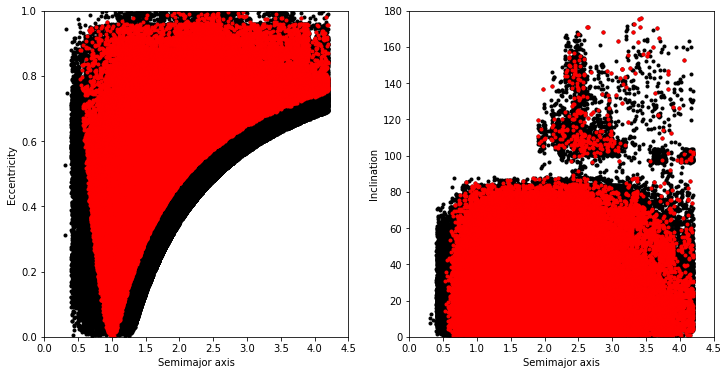

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(model.a, model.e, 'k.')
plt.plot(pha.a, pha.e, 'r.')
plt.xlabel('Semimajor axis')
plt.ylabel('Eccentricity')
plt.ylim(0, 1)
plt.xlim(0, 4.5)
plt.subplot(1,2,2)
plt.plot(model.a, model.inc, 'k.')
plt.plot(pha.a, pha.inc, 'r.')
plt.xlabel('Semimajor axis')
plt.ylabel('Inclination')
plt.ylim(0, 180)
plt.xlim(0, 4.5)

(0, 180)

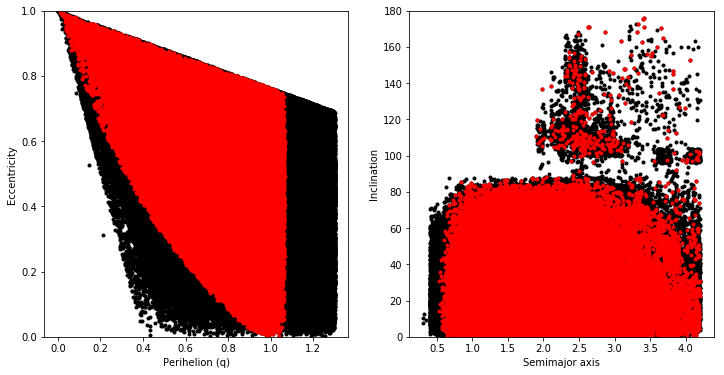

In [19]:
model = model.assign(q = model.a * (1 - model.e))
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(model.q, model.e, 'k.')
plt.plot(pha.q, pha.e, 'r.')
plt.xlabel('Perihelion (q)')
plt.ylabel('Eccentricity')
plt.ylim(0, 1)
#plt.xlim(0, 7)
plt.subplot(1,2,2)
plt.plot(model.a, model.inc, 'k.')
plt.plot(pha.a, pha.inc, 'r.')
plt.xlabel('Semimajor axis')
plt.ylabel('Inclination')
plt.ylim(0, 180)
#plt.xlim(0, 7)

792645.4979679816 801999 0.9883372647197586


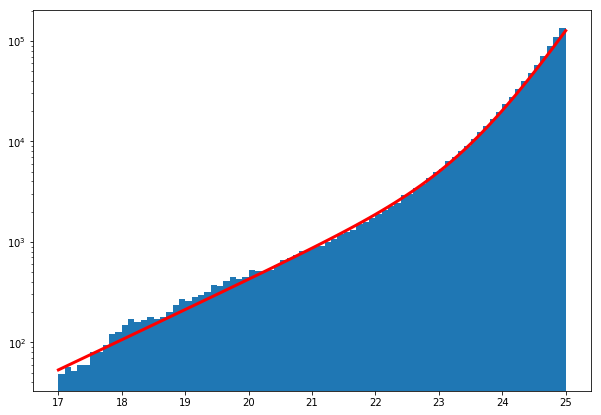

In [20]:
plt.figure(figsize=(10, 7))
bins = np.arange(17, 25.05, 0.1)
n, b, p = plt.hist(model.H, bins=bins, normed=False)
x = np.arange(17, 25.05, 0.1)
def dndh(hval):
    indx1 = (np.abs(hval - 18.2)).argmin()
    indx2 = (np.abs(hval - 22.5)).argmin()
    y0 = 0 # 10 * np.power(10, 0.55 * (x - 17))
    y1 = 150 * np.power(10, 0.3 * (x - 18.5))
    y2 = 2500 * np.power(10, 0.92 * (x - 23.2))
    return y0 + y1 + y2
y = dndh(x)
plt.plot(x, y, 'r-', linewidth=3)
plt.yscale('log')
print(y.cumsum()[-1], len(model), y.cumsum()[-1]/len(model))

In [21]:
model.H.max()

25.0

151877.4378571728 143742 1.056597500084685


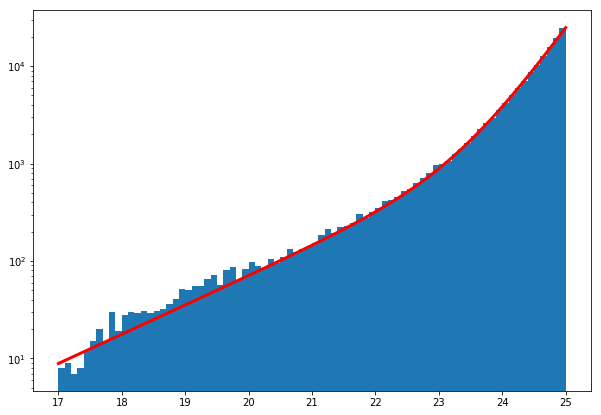

In [22]:
plt.figure(figsize=(10, 7))
bins = np.arange(17, 25.05, 0.1)
n, b, p = plt.hist(pha.H, bins=bins, normed=False)
x = np.arange(17, 25.05, 0.1)
def dndh(hval):
    indx1 = (np.abs(hval - 18.2)).argmin()
    indx2 = (np.abs(hval - 22.5)).argmin()
    y0 = 0 # 10 * np.power(10, 0.55 * (x - 17))
    y1 = 25 * np.power(10, 0.3 * (x - 18.5))
    y2 = 500 * np.power(10, 0.92 * (x - 23.2))
    return y0 + y1 + y2
y = dndh(x)
plt.plot(x, y, 'r-', linewidth=3)
plt.yscale('log')
print(y.cumsum()[-1], len(pha), y.cumsum()[-1]/len(pha))

In [23]:
# snapshot
from lsst.sims.movingObjects import PyOrbEphemerides

pyephs = PyOrbEphemerides()
pyephs.setOrbits(subset)
ephs = pyephs.generateEphemerides(times = [subset.orbits.epoch.iloc[0]])

Text(0, 0.5, 'Dec')

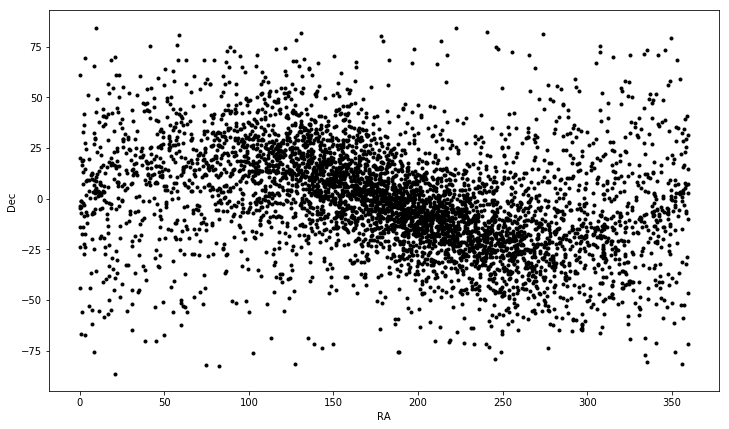

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(ephs['ra'], ephs['dec'], 'k.')
plt.xlabel('RA')
plt.ylabel('Dec')